In [1]:
# Import all modules for model building
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import Add, concatenate

# Import all modules for losses and training
import skimage.measure
import numpy as np
import cv2
from scipy.optimize import linear_sum_assignment
from math import exp, isnan, pow, ceil
from tensorflow.keras.metrics import Precision, Recall, IoU
from tensorflow.keras.callbacks import ModelCheckpoint

# Import all modules for data providing
import glob
import itertools
import os
import random
from sklearn.model_selection import train_test_split

# Define model of ResNet50 backbone

In [2]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    y = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    y = BatchNormalization(name=bn_name_base + '2a')(y)
    y = Activation('relu')(y)

    y = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(y)
    y = BatchNormalization(name=bn_name_base + '2b')(y)
    y = Activation('relu')(y)

    y = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(y)
    y = BatchNormalization(name=bn_name_base + '2c')(y)

    y = Add()([y, input_tensor])
    y = Activation('relu')(y)
    return y


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    y = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    y = BatchNormalization(name=bn_name_base + '2a')(y)
    y = Activation('relu')(y)

    y = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(y)
    y = BatchNormalization(name=bn_name_base + '2b')(y)
    y = Activation('relu')(y)

    y = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(y)
    y = BatchNormalization(name=bn_name_base + '2c')(y)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    y = Add()([y, shortcut])
    y = Activation('relu')(y)
    return y


def ResNet50(input_shape, refinenet=False, deeplab=False):
    """Instantiates the ResNet50 architecture.
    # Arguments
    input_shape: tuple 
        Input image shape with chanels
    refinenet: bool, optional
        Is this ResNet50 used in RefineNet
    deeplab: bool, optional
        Is this ResNet50 used in DeepLabV3
    # Returns
        A tensorflow.keras.Model instance of ResNet50
    """
    img_input = Input(input_shape)

    out = []

    x = ZeroPadding2D((2, 2))(img_input)
    x = Conv2D(64, (5, 5), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    if refinenet:
        out.append(x)

    if deeplab:
        out.append(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    if refinenet:
        out.append(x)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    if refinenet:
        out.append(x)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    out.append(x)

    return Model(img_input, out)

In [3]:
    def focal_loss(y_true, y_pred):
     # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= tf.math.reduce_sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        alpha = 0.25
        gamma = 3

        # Calculate Cross Entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        # return K.sum(loss, axis=1)
        f_loss = tf.math.reduce_sum(loss, axis=1)
        return f_loss

# Define DeepLabV3 decoder and whole model

In [4]:
def conv_block_DSPP(input, n_filters=256, kernel_size=3, dilation_rate=1):
    """
    Convolutional block - part of Dilated Spatial Pyramid Pooling module.
    # Arguments:
    input: Keras tensor
        Tensor from previous layer
    n_filters: int, optional
        Channel number of output feature map
    kernel_size: int, optional
        Size of convolutional kernel
    dilation_rate: int, optional
        Dilation rate used only in DSPP block
    # Returns:
        Keras tensor output of conv block
    """
    x = Conv2D(n_filters, kernel_size, dilation_rate=dilation_rate,
        padding="same", use_bias=False)(input)
    x = BatchNormalization()(x)
    return Activation('relu')(x)


def DSPP(input):
    """"
    Dilated Spatial Pyramid Pooling module (DSPP) - part of DeepLabv3
    # Arguments:
    input: Keras tensor
        Tensor from previous layer
    # Returns:
        Keras tensor output of DSPP block
    """
    input_shape = input.shape
    x = AveragePooling2D(pool_size=(input_shape[-3], input_shape[-2]))(input)
    x = conv_block_DSPP(x, kernel_size=1)
    out_pool = UpSampling2D(size=(input_shape[-3] // x.shape[1], input_shape[-2] // x.shape[2]), 
        interpolation="bilinear")(x)
    out_1 = conv_block_DSPP(input, kernel_size=1, dilation_rate=1)
    out_6 = conv_block_DSPP(input, kernel_size=3, dilation_rate=6)
    out_12 = conv_block_DSPP(input, kernel_size=3, dilation_rate=12)
    out_18 = conv_block_DSPP(input, kernel_size=3, dilation_rate=18)

    x = concatenate([out_pool, out_1, out_6, out_12, out_18])
    return conv_block_DSPP(x, kernel_size=1)


def DeepLabV3(input_shape, nb_classes):
    """
    Build DeepLabV3+ semantic segmentation model with ResNet50 as backbone
    # Arguments:
    input_shape: tuple
        Tuple of input image shape (width, height, number_of_channels)
    nb_classes: int
        Number of classes used in segmentation data
    # Returns:
        Tensorflow.keras.Model of DeepLabV3
    """
    res = ResNet50(input_shape, deeplab=True)  # backbone model
    input = res.input  # get input
    res_outs = res.output  # get ResNet50 outputs
    x = res_outs[1]  # main output W // 32, H // 32
    x = DSPP(x)  # build DSPP block

    x = UpSampling2D(size=(input_shape[0] / 4 // x.shape[1], input_shape[1] / 4 // x.shape[2]),
        interpolation="bilinear")(x)  # upsample by 4
    y = res_outs[0]  # get output of W // 4, H // 4
    y = conv_block_DSPP(y, kernel_size=1)
    x = concatenate([x, y])  # concat 2 feature maps
    x = conv_block_DSPP(x)
    x = conv_block_DSPP(x)
    x = UpSampling2D(size=(input_shape[0] // x.shape[1], input_shape[1] // x.shape[2]),
        interpolation="bilinear")(x)  # upsample to original shape

    x = Conv2D(nb_classes, 1, padding="same")(x)  # build output feature map and apply activation
    x = Activation('softmax')(x)
    return Model(input, x)

# Define utils: data generators, pair collectors and focal loss

In [5]:
import tensorflow as tf
def get_pairs_from_paths_AERIAL(images_path, segs_path, val_size=0.2):
    "Get list of pairs image-label from folder for AERIAL VEHICLE dataset"
    images = os.listdir(images_path)
    segmentations = os.listdir(segs_path)
    images = list(set(images) & set(segmentations))
    random.shuffle(images)
    pairs = [(os.path.join(images_path, img), os.path.join(segs_path, img)) for img in images]
    return train_test_split(pairs, test_size=val_size)
  
def get_pairs_from_paths_UAV(images_path, segs_path, images_path_all, segs_path_all,
                         val_size=0.2):
    images = os.listdir(images_path)
    segmentations = os.listdir(segs_path)
    images_target = list(set(images) & set(segmentations))
    
    images = os.listdir(images_path_all)
    segmentations = os.listdir(segs_path_all)
    images_all = list(set(images) & set(segmentations) - set(images_target))
    
    random.shuffle(images_all)
    images = images_target + images_all[:3*len(images_target)]
    
    pairs = [(os.path.join(images_path_all, img), os.path.join(segs_path_all, img)) for img in images]
    
    return train_test_split(pairs, test_size=val_size)
  
class DataGenerator(tf.keras.utils.Sequence):
    """
    Data generator for CPAnet 
    yields X, main_output
    """
    def __init__(self, pairs, input_shape, num_classes, 
                 steps_per_epoch=1000, batch_size = 32):
        self.pairs = pairs  # list with pairs of image-mask
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.steps_per_epoch = steps_per_epoch  # less for validation
        
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.steps_per_epoch
    
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        random.shuffle(self.pairs)
        
        
    def get_mask(self, path):
        "Load mask from path"
        seg_label = np.zeros((self.input_shape[0], self.input_shape[1], 
                               self.num_classes))  # create label array
        mask = cv2.imread(path, 1)  # load mask
        mask = cv2.resize(mask, self.input_shape, 
                          interpolation=cv2.INTER_NEAREST)  # resize mask
        mask = mask[:, : , 0]  # get one chanel mask

        for c in range(self.num_classes):
            seg_label[:, :, c] = (mask == c).astype(int)  # fill label array
            
        return seg_label  # return without reshaping
      
      
    def get_image(self, path):
        "Load image from path"
        img = cv2.imread(path, 1)  # load mask
        img = cv2.resize(img, self.input_shape)  # resize mask
        img = img.astype(np.float32)  # convert to float
        img /= 255.0  # normalize image
        return img
    
    
    def get_batch(self, batch_pairs):
        "Get batch of input image and output masks"
        images = []  # create empty lists for images and masks
        masks = []
        for pair in batch_pairs:  # iterate over batch pairs
            img = self.get_image(pair[0])  # load image and mask
            mask = self.get_mask(pair[1])
            images.append(img)  # append to lists
            masks.append(mask)
        images = np.array(images)  # convert to arrays
        masks = np.array(masks)
        return images, masks
    
    
    def __getitem__(self, index):
        "Get item - batch with index"
        batch_pairs = self.pairs[index * self.batch_size : 
                                 (index + 1) * self.batch_size]  # get batch pairs
        images, masks = self.get_batch(batch_pairs)  # get batch
        return images, masks
      
    def focal_loss(y_true, y_pred):
     # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= tf.math.reduce_sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        alpha = 0.25
        gamma = 3

        # Calculate Cross Entropy
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        # return K.sum(loss, axis=1)
        f_loss = tf.math.reduce_sum(loss, axis=1)
        return f_loss

# Build model, configure and start training

In [6]:
from tensorflow.keras.layers import AveragePooling2D

# Model params
INPUT_SHAPE = (512, 512, 3)
BATCH_SIZE = 4
EPOCHS = 20
STEPS_PER_EPOCH = 1000
N_CLASSES = 2

# UAV Dataset pathes
IMAGE_PATH_UAV = "/kaggle/input/drone-detection-dataset/crops_with_target/crops_with_target"
MASK_PATH_UAV = "/kaggle/input/drone-detection-dataset/masks_with_target/masks_with_target"

IMAGE_PATH_ALL = "/kaggle/input/drone-detection-dataset/images_cropped/images_cropped"
MASK_PATH_ALL = "/kaggle/input/drone-detection-dataset/masks_cropped/masks_cropped"

# AERIAL Dataset pathes
IMAGE_PATH_AERIAL = "/kaggle/input/aerial/images"
MASK_PATH_AERIAL = "/kaggle/input/aerial/masks"

# Weight path
WEIGTH_PATH = ""

# Build model
deeplab = DeepLabV3(INPUT_SHAPE, N_CLASSES)

# Set train and validation generators
#train_pairs, val_pairs = get_pairs_from_paths_UAV(IMAGE_PATH_UAV, MASK_PATH_UAV, 
                                                 # IMAGE_PATH_ALL, MASK_PATH_ALL)
train_pairs, val_pairs = get_pairs_from_paths_AERIAL(IMAGE_PATH_AERIAL, MASK_PATH_AERIAL)
train_pairs_UAV, val_pairs_UAV = get_pairs_from_paths_UAV(IMAGE_PATH_UAV, MASK_PATH_UAV, 
                                                 IMAGE_PATH_ALL, MASK_PATH_ALL)
train_pairs = train_pairs + train_pairs_UAV
val_pairs = val_pairs + val_pairs_UAV
train_gen = DataGenerator(train_pairs, INPUT_SHAPE[:2], N_CLASSES, STEPS_PER_EPOCH, BATCH_SIZE)
val_gen = DataGenerator(val_pairs, INPUT_SHAPE[:2], N_CLASSES, 400, BATCH_SIZE)

# Compile model and load weights
deeplab.compile(loss=focal_loss,
            optimizer="adam",
            metrics=[Precision(class_id = 1), Recall(class_id = 1)])

#deeplab.load_weights(WEIGTH_PATH)

CHECKPOINT_PATH = "/kaggle/working/DEEPLAB-AERIAL-UAV-FCE-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(CHECKPOINT_PATH, save_weights_only=True, verbose=1, period=5)
callbacks_list = [checkpoint]

# Train model
history = deeplab.fit(train_gen, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS,
                        validation_data = val_gen, callbacks=callbacks_list)

Epoch 1/20
1000/1000 [==============================] - 399s 345ms/step - loss: 0.2603 - precision: 0.2328 - recall: 0.2412 - val_loss: 0.1239 - val_precision: 0.7673 - val_recall: 0.0466
Epoch 2/20
1000/1000 [==============================] - 336s 336ms/step - loss: 0.0263 - precision: 0.6516 - recall: 0.3162 - val_loss: 0.0740 - val_precision: 0.0022 - val_recall: 0.0033
Epoch 3/20
1000/1000 [==============================] - 332s 332ms/step - loss: 0.0201 - precision: 0.6988 - recall: 0.4003 - val_loss: 0.0219 - val_precision: 0.7238 - val_recall: 0.4974
Epoch 4/20
1000/1000 [==============================] - 330s 330ms/step - loss: 0.0174 - precision: 0.7263 - recall: 0.4521 - val_loss: 0.0264 - val_precision: 0.8179 - val_recall: 0.3969
Epoch 5/20
1000/1000 [==============================] - ETA: 0s - loss: 0.0156 - precision: 0.7389 - recall: 0.4773
Epoch 5: saving model to /kaggle/working/DEEPLAB-AERIAL-UAV-FCE-05.h5
1000/1000 [==============================] - 330s 330ms/step -

# Visualize predictions

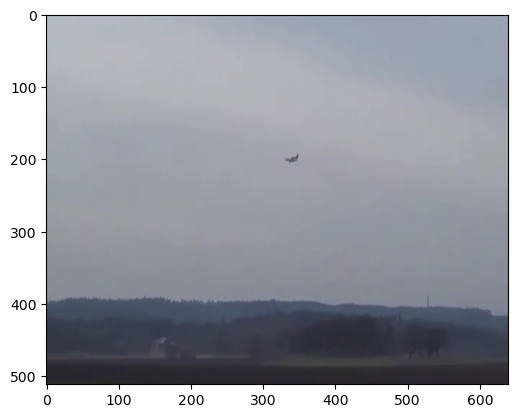

In [7]:
import cv2
import matplotlib.pyplot as plt

img_path = "/kaggle/input/aerial/images/AIRPLANE_000191.png"
image = cv2.imread(img_path)

# Check if the image is successfully loaded
if image is None:
    print(f"Error: Unable to load the image from {img_path}")
else:
    # Convert the image to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using plt.imshow
    plt.figure()
    plt.imshow(image_rgb)
    plt.show()


1/1 [==============================] - 2s 2s/step


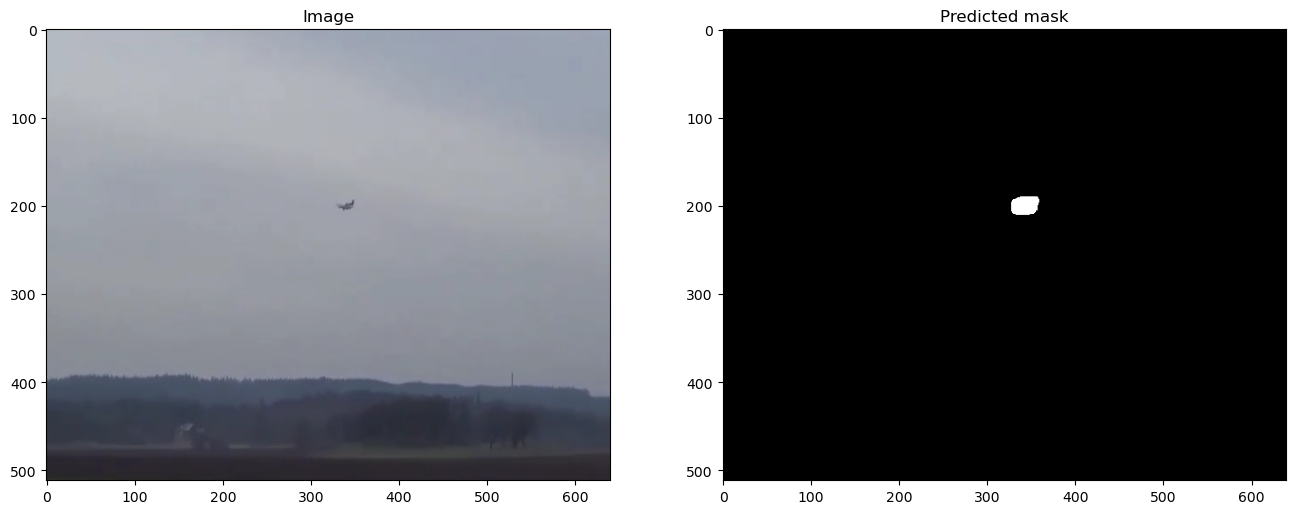

In [8]:
def predict(model, image, thresh, mode):
    input_shape = model.input_shape[1:]  # get input shape
    img_shape = image.shape  # get image shape
    img2predict = cv2.resize(image, input_shape[:2])
    pred = model.predict(img2predict.reshape((1,) + input_shape) / 255)
    pred = (pred[0,:,:,1] > thresh) * 255  # get prediction according to threshold
    pred = cv2.resize(pred, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_NEAREST)  # resize mask
    plt.figure(figsize=(16,8))
    
    if mode == "mask":
        plt.subplot(1, 2, 1, title="Image")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2, title="Predicted mask")
        plt.imshow(pred, cmap = "gray")
        
    if mode == "bbox":
        bboxes = regionprops(label(pred))  # get list of objects
        image1 = image.copy()  # copy image to draw bboxes
        for bbox in bboxes:
            y1, x1, y2, x2 = bbox.bbox
            image1=cv2.rectangle(image1, (x1, y1), (x2, y2), (255, 0, 0), 1)  # draw rectangle
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        plt.title("Predicted objects")
        
        
predict(deeplab, image, 0.5, mode="mask")

In [9]:
print(history.history['loss'])
import pickle
f = open("deeplab.pkl","wb")
pickle.dump(history.history,f)

# close file
f.close()

[0.2602654993534088, 0.026275986805558205, 0.020133549347519875, 0.01736762747168541, 0.015618695877492428, 0.014453250914812088, 0.014842940494418144, 0.017573969438672066, 0.015135238878428936, 0.014811791479587555, 0.012930330820381641, 0.015583598986268044, 0.01193355955183506, 0.010285535827279091, 0.012859931215643883, 0.01263351645320654, 0.011130133643746376, 0.012330716475844383, 0.011936165392398834, 0.009919569827616215]


1/1 [==============================] - 0s 34ms/step


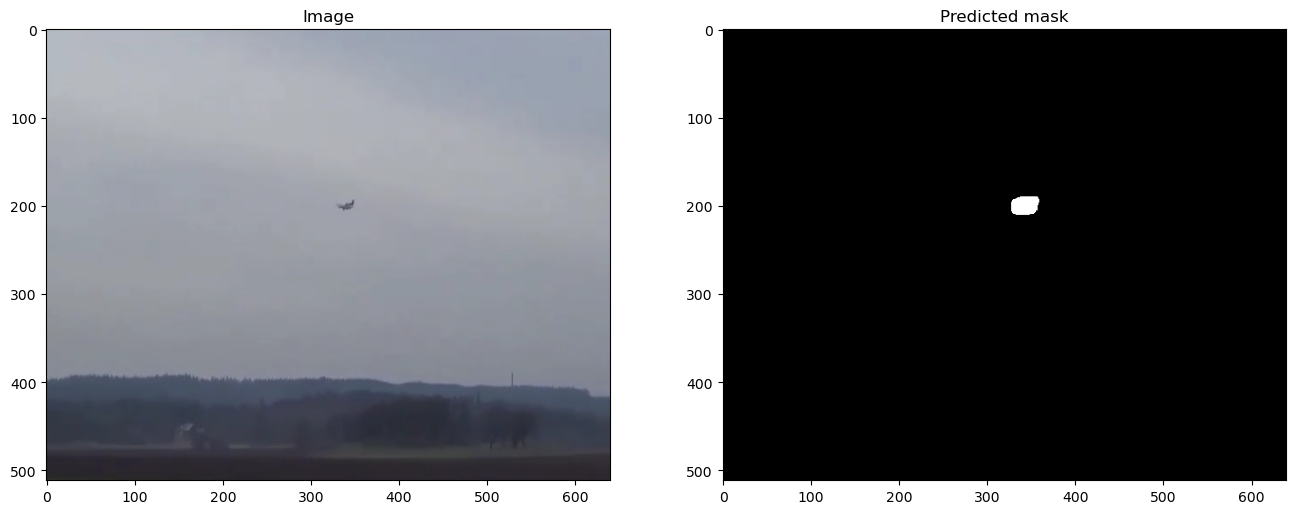

In [10]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def predict(model, image, thresh, mode):
    input_shape = model.input_shape[1:]  # get input shape
    img_shape = image.shape  # get image shape
    img2predict = cv2.resize(image, input_shape[:2])
    pred = model.predict(img2predict.reshape((1,) + input_shape) / 255)
    pred = (pred[0, :, :, 1] > thresh) * 255  # get prediction according to threshold
    pred = cv2.resize(pred, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_NEAREST)  # resize mask
    plt.figure(figsize=(16, 8))

    if mode == "mask":
        plt.subplot(1, 2, 1, title="Image")
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2, title="Predicted mask")
        plt.imshow(pred, cmap="gray")

    if mode == "bbox":
        bboxes = regionprops(label(pred))  # get list of objects
        image1 = image.copy()  # copy image to draw bboxes
        for bbox in bboxes:
            y1, x1, y2, x2 = bbox.bbox
            image1 = cv2.rectangle(image1, (x1, y1), (x2, y2), (255, 0, 0), 1)  # draw rectangle
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
        plt.title("Predicted objects")


predict(deeplab, image, 0.5, mode="mask")